In [212]:
import opendatasets as od
import os
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchvision.transforms as tt

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
od.download('https://www.kaggle.com/pavelbiz/eyes-rtte')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dikshantkalotra
Your Kaggle Key: ··········


100%|██████████| 40.4M/40.4M [00:01<00:00, 36.1MB/s]


In [213]:
data_dir = './eyes-rtte'
print(os.listdir(data_dir))
print('No of female eyes : ',len(os.listdir(data_dir + '/femaleeyes')), ' |||| No of male eyes : ',len(os.listdir(data_dir + '/maleeyes')))

['maleeyes', 'femaleeyes']
No of female eyes :  5202  |||| No of male eyes :  6323


In [214]:
dataset = ImageFolder(data_dir, transform = ToTensor())

In [215]:
dataset.classes

['femaleeyes', 'maleeyes']

In [216]:
dataset

Dataset ImageFolder
    Number of datapoints: 11525
    Root location: ./eyes-rtte
    StandardTransform
Transform: ToTensor()

In [217]:
def show_example(img, label):
    print('Label : ', dataset.classes[label], '  Image size : ', img.shape)
    plt.imshow(img.permute(1,2,0))

## Images before transforming

Label :  femaleeyes   Image size :  torch.Size([3, 53, 53])


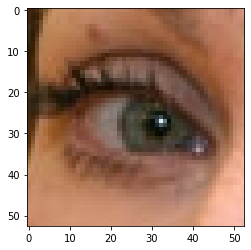

In [218]:
show_example(*dataset[0])

Label :  maleeyes   Image size :  torch.Size([3, 48, 48])


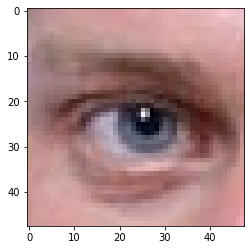

In [219]:
show_example(*dataset[10011])

In [220]:
def lowest_size(dataset):
    lowest_x, lowest_y = 100000 , 100000
    for img, label in dataset:
        if img.shape[1] < lowest_x:
            lowest_x = img.shape[1]
        if img.shape[2] < lowest_y:
            lowest_y = img.shape[2]
    return lowest_x, lowest_y

In [221]:
print(lowest_size(dataset))

(41, 41)


In [222]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
dataset = ImageFolder(data_dir, transform = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                                                        tt.RandomHorizontalFlip(), 
                                                        tt.ToTensor(), 
                                                        tt.Normalize(*stats,inplace=True)]))

## Images after transforming

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :  femaleeyes   Image size :  torch.Size([3, 32, 32])


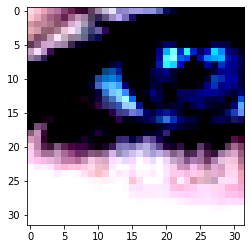

In [223]:
show_example(*dataset[11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :  maleeyes   Image size :  torch.Size([3, 32, 32])


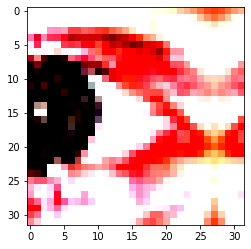

In [224]:
show_example(*dataset[10001])

In [225]:
valid_size = int(len(dataset)*0.25)
test_size = int(valid_size * 0.01)
train_size = len(dataset) - valid_size - test_size

print('Training Size : ',train_size,'\nValidation Size : ',valid_size, '\nTesting Size : ', test_size)

Training Size :  8616 
Validation Size :  2881 
Testing Size :  28


In [226]:
train_ds, valid_ds, test_ds = random_split(dataset, [train_size, valid_size, test_size])
len(train_ds), len(valid_ds), len(test_ds)

(8616, 2881, 28)

In [130]:
batch_size = 128

In [133]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [132]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss.detach(), 'val_acc' : acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [135]:
class Conv2dModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_size, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256, out_size))
        
    def forward(self, xb):
        return self.network(xb)

In [136]:
model = Conv2dModel(3,2)
model

Conv2dModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveMaxPool2d(output_size=1)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Dropout(p=0.2, inplace=False)
    (18): Linear(in_feature

In [137]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device , non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [138]:
device = get_default_device()
device

device(type='cuda')

In [139]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

Conv2dModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveMaxPool2d(output_size=1)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Dropout(p=0.2, inplace=False)
    (18): Linear(in_feature

In [140]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [141]:
evaluate(model, valid_dl)

{'val_acc': 0.4486177861690521, 'val_loss': 0.6942799091339111}

In [142]:
history = fit(10, 0.0003, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.6772, val_loss: 0.6692, val_acc: 0.5937
Epoch [1], train_loss: 0.6429, val_loss: 0.6174, val_acc: 0.6551
Epoch [2], train_loss: 0.5545, val_loss: 0.5181, val_acc: 0.7471
Epoch [3], train_loss: 0.4823, val_loss: 0.4843, val_acc: 0.7504
Epoch [4], train_loss: 0.4643, val_loss: 0.4263, val_acc: 0.8040
Epoch [5], train_loss: 0.4189, val_loss: 0.3987, val_acc: 0.8152
Epoch [6], train_loss: 0.4069, val_loss: 0.3999, val_acc: 0.8270
Epoch [7], train_loss: 0.3854, val_loss: 0.4426, val_acc: 0.8039
Epoch [8], train_loss: 0.3792, val_loss: 0.3898, val_acc: 0.8262
Epoch [9], train_loss: 0.3709, val_loss: 0.3369, val_acc: 0.8525


In [143]:
history += fit(10, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3385, val_loss: 0.3805, val_acc: 0.8335
Epoch [1], train_loss: 0.3282, val_loss: 0.3276, val_acc: 0.8586
Epoch [2], train_loss: 0.3266, val_loss: 0.3610, val_acc: 0.8453
Epoch [3], train_loss: 0.3161, val_loss: 0.3073, val_acc: 0.8661
Epoch [4], train_loss: 0.3240, val_loss: 0.3275, val_acc: 0.8421
Epoch [5], train_loss: 0.3129, val_loss: 0.3165, val_acc: 0.8686
Epoch [6], train_loss: 0.3123, val_loss: 0.3090, val_acc: 0.8690
Epoch [7], train_loss: 0.3110, val_loss: 0.3166, val_acc: 0.8622
Epoch [8], train_loss: 0.3117, val_loss: 0.3070, val_acc: 0.8602
Epoch [9], train_loss: 0.3044, val_loss: 0.2925, val_acc: 0.8723


In [148]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

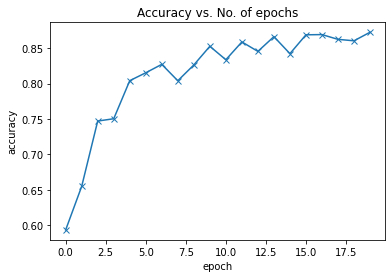

In [149]:
plot_accuracies(history)

In [153]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

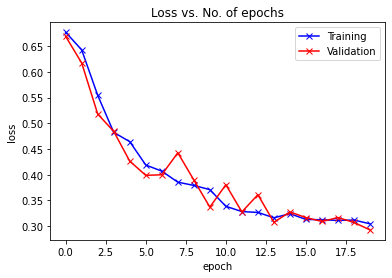

In [154]:
plot_losses(history)

# Testing Phase

In [179]:
mean, std = stats

[mean, std]

[(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.201)]

In [163]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

Label: femaleeyes , Predicted: femaleeyes


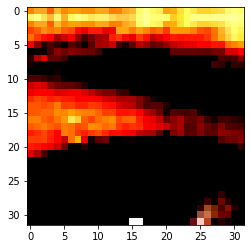

In [274]:
img, label = test_ds[27]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: maleeyes , Predicted: maleeyes


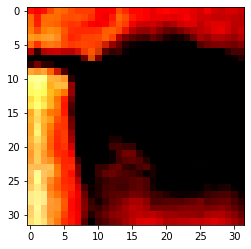

In [278]:
img, label = test_ds[8]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: maleeyes , Predicted: maleeyes


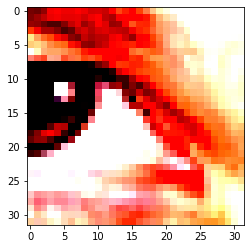

In [282]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [283]:
torch.save(model.state_dict(), 'conv2dModel.pth')